# Images Preprocessing 

## About dataset
There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

The dataset is organized into 3 folders:
* train 
* test
* val 


Each folder contains subfolders for each image category:
* Pneumonia
* Normal 
-----------
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

**For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans.** The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

---------

Necessary Libraires or packages are:
- TensorFlow
- Keras
- Numpy
- Hyperas, Hyperopt
- Matplotlib, Seaborn

### Choosing Right Metrics
Before we start we need to clearly understand our problem at hand then, choose a metric to measure the performance of our model and loss function on which we intend to do our optimization. Our problem is a general image classification task for which we have chosen accuracy as the metric and categorical cross-entropy as our loss function.

We are only provided with a train and test set as we also need a validation set we use scikit-learn’s train-test split to split train data obtained into 80% train and 20% validation

*Train set is the set of data-points on which the model learns/trains, Validation set is used to compare between models and Test set to see how well does our model generalize to unseen input (input which we have not trained upon)*

In [20]:
# Importing the necessary libraries
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import os
import sys
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import time
import scipy
from PIL import Image

from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [17]:
# set file path for x-ray
#----------
# all files 
folder_path = 'data/'
# we have three folders for images dataset
set_list = ['train','test','val']

At the beginning of a project, a data scientist divides up all the examples into three subsets: the training set, the validation set, and the test set. Common ratios used are:

- 70% train, 15% val, 15% test
- 80% train, 10% val, 10% test
- 60% train, 20% val, 20% test

In [40]:
normal = []
pneumonia = []
image_count = 0
# check size of dataset:
for i, _set in enumerate(set_list):
    normal.append(len(os.listdir(folder_path + _set + '/NORMAL')))
    pneumonia.append(len(os.listdir(folder_path + _set + '/PNEUMONIA')))
    image_count +=normal[i]+pneumonia[i]
    print('{} dataset has {} images: {} normal and {} infected'.format(_set, normal[i]+pneumonia[i], normal[i], pneumonia[i]))

train dataset has 5216 images: 1341 normal and 3875 infected
test dataset has 624 images: 234 normal and 390 infected
val dataset has 16 images: 8 normal and 8 infected


In [46]:
for i, _set in enumerate(set_list):
        print('{} dataset has {} images: {} normal and {} infected'.format(_set, 
                                                                           round((normal[i]+pneumonia[i])/image_count*100,2), 
                                                                           round(normal[i]/image_count*100,2),
                                                                           round(pneumonia[i]/image_count*100,2)))


train dataset has 89.07 images: 22.9 normal and 66.17 infected
test dataset has 10.66 images: 4.0 normal and 6.66 infected
val dataset has 0.27 images: 0.14 normal and 0.14 infected


Text(0.5, 1.0, 'Dataset Distribution')

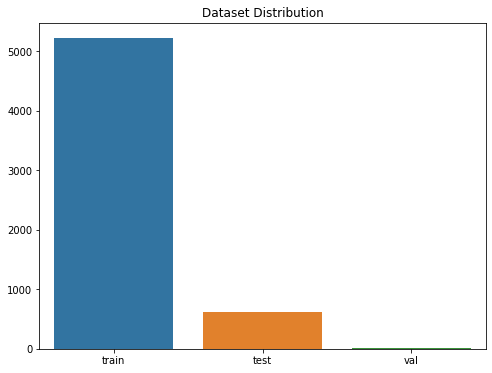

In [21]:
# Plot the dataset distribution
plt.figure(figsize=(8,6))
sns.barplot(set_list,[normal[0]+pneumonia[0],normal[1]+pneumonia[1],normal[2]+pneumonia[2]])
plt.title('Dataset Distribution')

Text(0.5, 1.0, 'Classes Distribution')

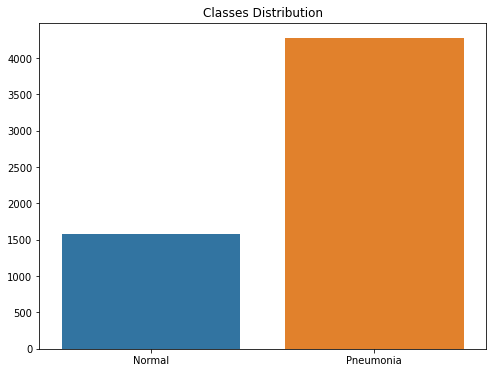

In [22]:
# Plot the class distribution
plt.figure(figsize=(8,6))
sns.barplot(['Normal','Pneumonia'],[normal[0]+normal[1]+normal[2],pneumonia[0]+pneumonia[1]+pneumonia[2]])
plt.title('Classes Distribution')

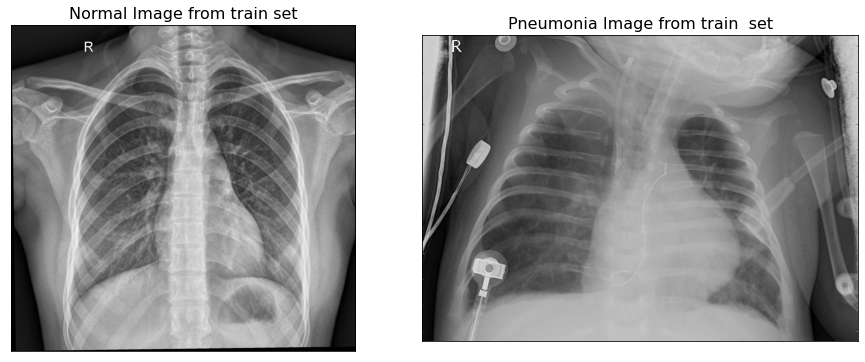

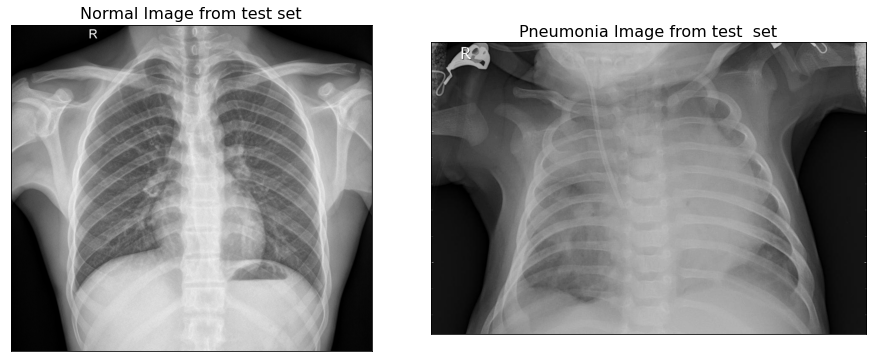

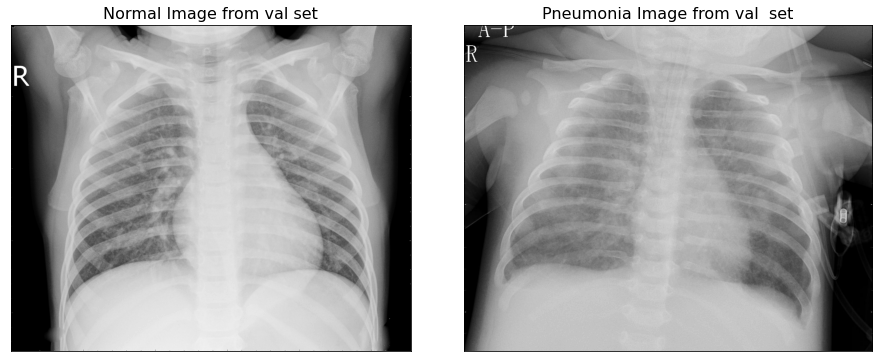

In [23]:
# Visual cheking 
for i, _set in enumerate(set_list):
    normal_img = glob(folder_path + _set + '/NORMAL/*.jpeg')
    pneumonia_img = glob(folder_path + _set + '/PNEUMONIA/*.jpeg')
    im_n = Image.open(normal_img[i]) 
    im_p = Image.open(pneumonia_img[i]) 
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(wspace=0.05)
    #fig.suptitle('Normal condition vs. Pneumonia')
    ax[0].imshow(im_n, cmap='gray')
    ax[0].set_title('Normal Image from ' + _set + ' set', size=16)
    ax[1].imshow(im_p, cmap='gray')
    ax[1].set_title('Pneumonia Image from ' + _set+'  set', size=16)

How we can see all images a clean , we don't have any black stops, jewelry, medical equipment

JPEG
L
(1632, 1225)


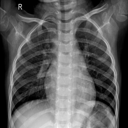

In [32]:
# Let's check our images. 
im = Image.open(normal_img[0]) 
#Get basic details about the image
print(im.format)
print(im.mode)
print(im.size)
out = im.resize((128, 128))
display(out)

Pneumonia positive images seems to be more faint as the borders between organs are less sharp because of the soft tissue (water) in the lungs.

* Black: Air
* Dark Grey: Fat
* Light Grey: Soft tissue
* Off white: Bone
* Bright white: Metal

In [48]:
img_class = []
height = []
weight = []
mode = []
iformat = []

# Iterate through each image path
for _set in set_list:
        # find height and width of all train images
        for image in glob(folder_path + _set + '/NORMAL/*.jpeg')+glob(folder_path + _set + '/PNEUMONIA/*.jpeg'):
                im = Image.open(image)
                img_array = np.array(Image.open(image))
                height.append(img_array.shape[0])
                weight.append(img_array.shape[1])
                mode.append(im.mode)
                iformat.append(im.format)

# save image sizes to data frame
size_df = pd.DataFrame({
    'class': img_class,
    'height': height,
    'width': weight,
    'mode': mode,
    'iformat': iformat
})

size_df

,class,height,width,mode,iformat
0,train,2234,2359,L,JPEG
1,train,1067,1422,L,JPEG
2,train,1357,1828,L,JPEG
3,train,1495,1854,L,JPEG
4,train,1966,2194,L,JPEG
...,...,...,...,...,...
5851,val,592,968,L,JPEG
5852,val,664,1152,L,JPEG
5853,val,712,1072,L,JPEG
5854,val,944,1416,L,JPEG


Text(0.5, 1.0, 'Image Size Distribution')

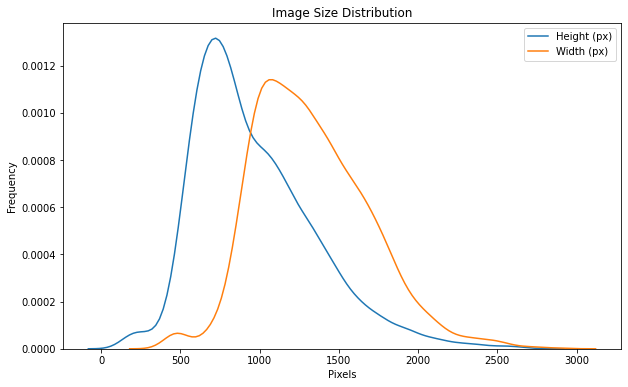

In [34]:
plt.figure(figsize = (10, 6))

sns.kdeplot(size_df['height'], label='Height (px)')
sns.kdeplot(size_df['width'], label='Width (px)')

plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')

That is very few examples to learn from, for a classification problem that is far from simple. So this is a challenging machine learning problem, but it is also a realistic one: in a lot of real-world use cases, even small-scale data collection can be extremely expensive or sometimes near-impossible (e.g. in medical imaging). Being able to make the most out of very little data is a key skill of a competent data scientist.

**Train folder** - contains the data for training our model and has 5216 images for training our model.

**Val folder** - contains images which we will use to validate our model. Here is only 16 images. Validation dataset we use to prevent overfitting, but 16 is not enough for this purpose.

**Test folder** - contains the data to test the model ***once***. Here is 624 images. And it's look like this amount of images better for validation data. 

Working on the model, we came to the conclusion that these images are better to use for validation.

In [28]:
# when I don't have library
import sys
!{sys.executable} -m pip install hyperas

  Using cached hyperas-0.4.1-py3-none-any.whl (9.1 kB)
     |████████████████████████████████| 170 kB 2.0 MB/s eta 0:00:01
  Using cached hyperopt-0.2.4-py2.py3-none-any.whl (964 kB)
     |████████████████████████████████| 455 kB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 121 kB 10.1 MB/s eta 0:00:01
     |████████████████████████████████| 118 kB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 9.7 MB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 6.0 MB/s eta 0:00:011
     |████████████████████████████████| 829 kB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 10.2 MB/s eta 0:00:01
     |████████████████████████████████| 151 kB 12.8 MB/s eta 0:00:01
     |████████████████████████████████| 125 kB 9.5 MB/s eta 0:00:01
     |████████████████████████████████| 163 kB 12.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 13.3 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 1.7 MB/s eta 0:00

  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=93930141e8fd6febfb0042bba4116657c86c923e2773d949e52cd782ada4624d
  Stored in directory: /Users/marigaldina/Library/Caches/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
  Created wheel for pandocfilters: filename=pandocfilters-1.4.2-py3-none-any.whl size=7856 sha256=77810363fbf41c9c0f758193b97415d28cbf1699cda28482e147d3570d48ba12
  Stored in directory: /Users/marigaldina/Library/Caches/pip/wheels/63/99/01/9fe785b86d1e091a6b2a61e06ddb3d8eb1bc9acae5933d4740
  Created wheel for pyrsistent: filename=pyrsistent-0.16.0-cp37-cp37m-macosx_10_9_x86_64.whl size=68845 sha256=733d282254f5e8a8acb13307ad46e39212ea3e9add29b8448b0c51a00636d0a0
  Stored in directory: /Users/marigaldina/Library/Caches/pip/wheels/22/52/11/f0920f95c23ed7d2d0b05f2b7b2f4509e87a20cfe8ea43d987
Successfully built future pandocfilters pyrsistent
